In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [28]:
# Define la ruta a la carpeta de datos procesados
path_processed = '../data/processed/'

# Lista de las clases que guardamos
clases = ['basal', 'adelante', 'atras', 'derecha', 'izquierda', 'reposo']

# Cargar cada archivo en un diccionario de DataFrames
# La clave será el nombre de la clase y el valor será el DataFrame
dataframes = {clase: pd.read_parquet(f'{path_processed}{clase}_data.parquet') for clase in clases}

# Verificamos que se cargaron bien, por ejemplo, viendo el tamaño de 'df_adelante'
print("Datos cargados exitosamente en el diccionario 'dataframes'.")
print(f"Muestras en el segmento 'adelante': {dataframes['adelante'].shape[0]}")

Datos cargados exitosamente en el diccionario 'dataframes'.
Muestras en el segmento 'adelante': 15360


In [30]:
# Identificar las columnas de señales (asumimos que son las mismas en todos los DFs)
signal_cols = [col for col in dataframes['basal'].columns if 'EXG Channel' in col]

# Crear una instancia del escalador
scaler = StandardScaler()

# Iterar sobre cada DataFrame en nuestro diccionario para normalizarlo
for clase, df in dataframes.items():
    print(f"Normalizando el segmento: {clase}")
    
    # Seleccionar solo las columnas de señal
    df_signals = df[signal_cols]
    
    # Ajustar y transformar los datos
    df_scaled_signals = scaler.fit_transform(df_signals)
    
    # Reemplazar las columnas originales con las normalizadas
    df[signal_cols] = df_scaled_signals

print("\n¡Todos los segmentos han sido normalizados!")

Normalizando el segmento: basal
Normalizando el segmento: adelante
Normalizando el segmento: atras
Normalizando el segmento: derecha
Normalizando el segmento: izquierda
Normalizando el segmento: reposo

¡Todos los segmentos han sido normalizados!


In [33]:
def calcular_features_rms_wl(df, window_size=256):
    """
    Toma un DataFrame de señales y calcula RMS y WL para cada canal.
    """
    df_features = df.copy()
    signal_cols = [col for col in df.columns if 'EXG Channel' in col]
    
    print(f"Calculando RMS y WL para {len(signal_cols)} canales...")
    
    for col in signal_cols:
        # --- Calcular RMS (Root Mean Square) ---
        df_features[f'RMS_{col}'] = np.sqrt(
            (df_features[col]**2)
            .rolling(window=window_size, min_periods=1)
            .mean()
        )
        
        # --- Calcular WL (Waveform Length) ---
        diferencias_abs = df_features[col].diff().abs()
        df_features[f'WL_{col}'] = diferencias_abs.rolling(window=window_size, min_periods=1).sum()
        
    print("¡Cálculo completado!")
    return df_features

Calculando RMS y WL para 8 canales...
¡Cálculo completado!


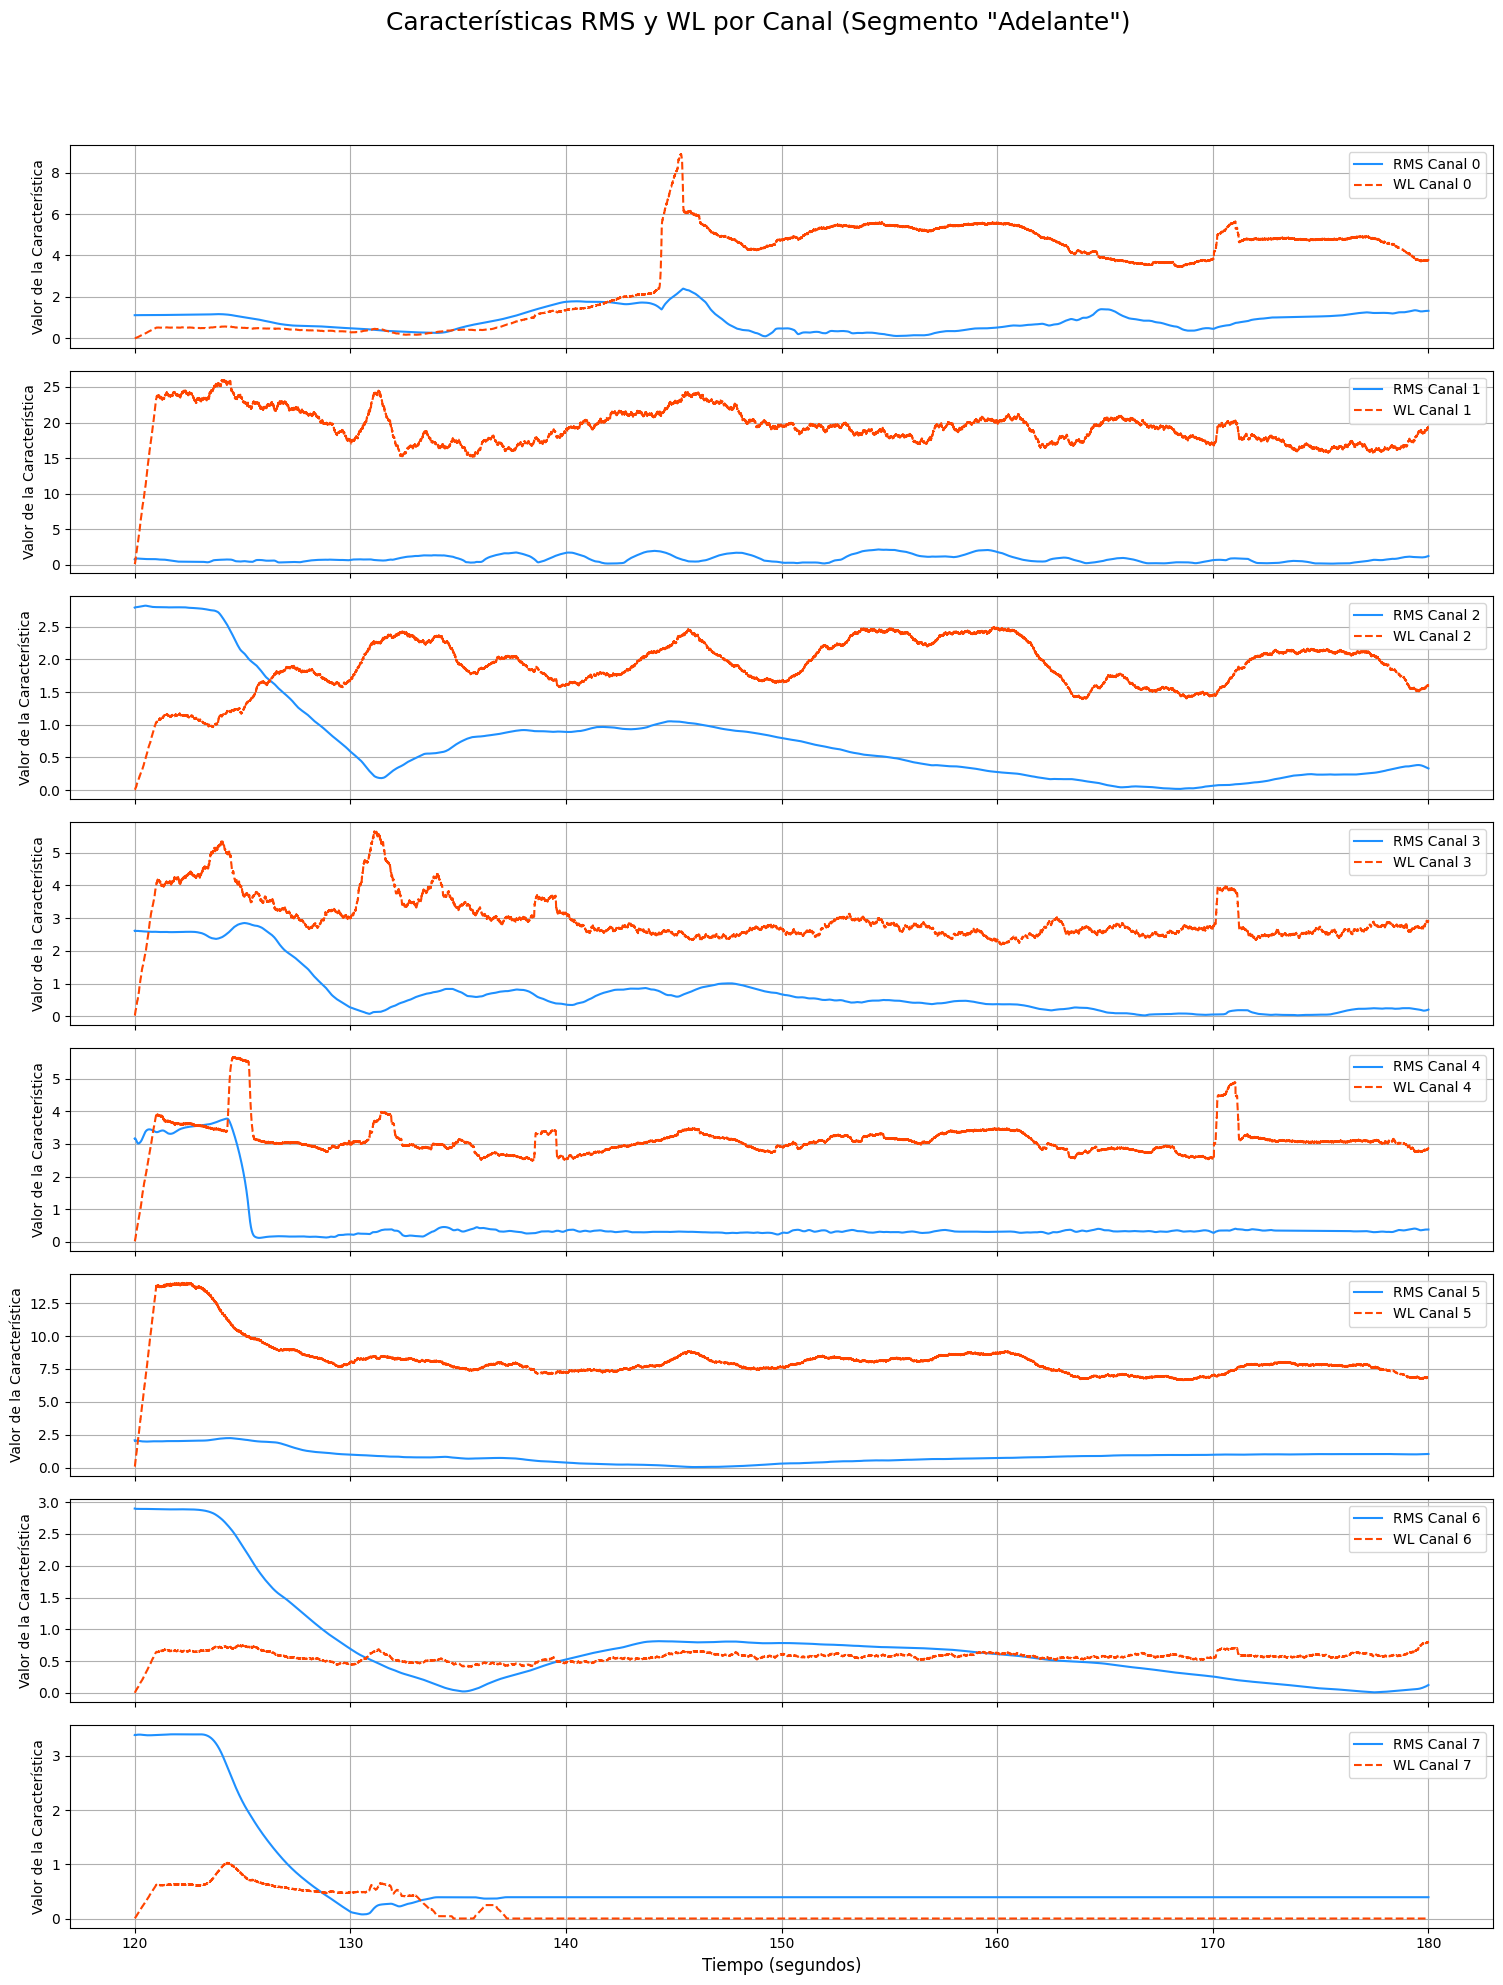

In [35]:
# --- Visualización de Características por Canal ---
# Vamos a usar el DataFrame del segmento 'adelante' que ya tiene las features calculadas
# (Asegúrate de haber corrido la celda que normaliza y calcula las features primero)

# Aplicamos la función para tener el DataFrame con características
df_adelante_features = calcular_features_rms_wl(dataframes['adelante'])


# Número de canales a graficar
num_channels = 8 # Asumiendo que tienes del canal 0 al 7

# Crear una figura con 8 subgráficos apilados verticalmente
fig, axes = plt.subplots(num_channels, 1, figsize=(15, 20), sharex=True)

# Título general para toda la figura
fig.suptitle('Características RMS y WL por Canal (Segmento "Adelante")', fontsize=18, y=1.02)

for i in range(num_channels):
    # Seleccionar el subgráfico (eje) actual
    ax = axes[i]
    
    # Nombres de las columnas para este canal
    rms_col = f'RMS_EXG Channel {i}'
    wl_col = f'WL_EXG Channel {i}'
    
    # Graficar RMS vs Tiempo
    ax.plot(df_adelante_features['time_seconds'], df_adelante_features[rms_col], label=f'RMS Canal {i}', color='dodgerblue')
    
    # Graficar WL vs Tiempo
    ax.plot(df_adelante_features['time_seconds'], df_adelante_features[wl_col], label=f'WL Canal {i}', color='orangered', linestyle='--')
    
    # Personalización de cada subgráfico
    ax.set_ylabel('Valor de la Característica')
    ax.grid(True)
    ax.legend()

# Añadir la etiqueta del eje X solo al último gráfico
axes[-1].set_xlabel('Tiempo (segundos)', fontsize=12)

# Ajustar el espaciado para que no se superpongan los títulos
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [34]:
lista_final_dfs = []

for clase, df in dataframes.items():
    print(f"Calculando características para: {clase}")
    
    # 1. Calcular características para el segmento actual
    df_con_features = calcular_features_rms_wl(df)
    
    # 2. Añadir la columna de clase
    df_con_features['Clase'] = clase
    
    # 3. Seleccionar SOLO las columnas que queremos conservar
    columnas_a_conservar = [col for col in df_con_features.columns if 'RMS_' in col or 'WL_' in col]
    columnas_a_conservar.append('Clase') # No nos olvidemos de la clase
    
    df_limpio = df_con_features[columnas_a_conservar]
    
    # 4. Añadir el DataFrame limpio a nuestra lista
    lista_final_dfs.append(df_limpio)

# --- Unificar todo en un solo DataFrame ---
df_final_features = pd.concat(lista_final_dfs, ignore_index=True)

# --- Limpiar los NaNs generados por .rolling() ---
df_final_features_limpio = df_final_features.dropna()

print("\n¡DataFrame final de características creado y limpiado!")

# --- Verificación Final ---
print(f"La forma del DataFrame final es: {df_final_features_limpio.shape}")
print("\nConteo de muestras por clase:")
print(df_final_features_limpio['Clase'].value_counts())
display(df_final_features_limpio.head())

Calculando características para: basal
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: adelante
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: atras
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: derecha
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: izquierda
Calculando RMS y WL para 8 canales...
¡Cálculo completado!
Calculando características para: reposo
Calculando RMS y WL para 8 canales...
¡Cálculo completado!

¡DataFrame final de características creado y limpiado!
La forma del DataFrame final es: (104804, 17)

Conteo de muestras por clase:
Clase
basal        30720
adelante     15359
atras        15359
derecha      15359
izquierda    15359
reposo       12648
Name: count, dtype: int64


,RMS_EXG Channel 0,WL_EXG Channel 0,RMS_EXG Channel 1,WL_EXG Channel 1,RMS_EXG Channel 2,WL_EXG Channel 2,RMS_EXG Channel 3,WL_EXG Channel 3,RMS_EXG Channel 4,WL_EXG Channel 4,RMS_EXG Channel 5,WL_EXG Channel 5,RMS_EXG Channel 6,WL_EXG Channel 6,RMS_EXG Channel 7,WL_EXG Channel 7,Clase
1,0.872088,0.000024,1.280368,0.005878,2.132244,0.000353,1.998439,0.001438,1.576958,0.039054,2.803140,0.336786,2.207718,0.017805,1.643290,0.003151,basal
2,0.875658,0.010704,1.296320,0.056102,2.129443,0.008945,2.000426,0.008114,1.582736,0.041188,2.780527,0.568515,2.203041,0.022946,1.643290,0.004727,basal
3,0.877819,0.012219,1.308854,0.074208,2.126982,0.013190,2.002133,0.010964,1.576158,0.079162,2.687670,0.915731,2.203554,0.034384,1.644015,0.007624,basal
4,0.876508,0.025244,1.305130,0.129838,2.125780,0.014571,2.001433,0.019581,1.571421,0.083091,2.648316,1.012881,2.204254,0.036342,1.644218,0.008781,basal
5,0.873829,0.036180,1.294588,0.179433,2.124787,0.015717,1.999626,0.027641,1.576304,0.131261,2.706917,1.510910,2.201815,0.053817,1.643536,0.013694,basal


In [36]:
# --- Guardar el DataFrame Final de Características ---

# 1. Definir la ruta y el nombre del archivo final
path_final = '../data/processed/final_feature_data.parquet'

print(f"Guardando el DataFrame final en: {path_final}")
print(f"Forma del DataFrame a guardar: {df_final_features_limpio.shape}")

# 2. Guardar en formato Parquet
df_final_features_limpio.to_parquet(path_final)

print("\n¡Archivo guardado exitosamente!")
print("El preprocesamiento y la ingeniería de características han terminado.")

Guardando el DataFrame final en: ../data/processed/final_feature_data.parquet
Forma del DataFrame a guardar: (104804, 17)

¡Archivo guardado exitosamente!
El preprocesamiento y la ingeniería de características han terminado.
